In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd

In [4]:
syn = np.load('cal_mags/caspec_mags_skymapper_all.npy',allow_pickle=True).item()
syn = pd.DataFrame(syn)
syn = syn.rename(columns={'SkyMapper.u':'u','SkyMapper.v':'v','SkyMapper.g':'g',
                          'SkyMapper.r':'r','SkyMapper.i':'i','SkyMapper.z':'z'})

synt = np.load('current_caspec_mags.npy',allow_pickle=True).item()

tonry = np.loadtxt('Tonry_splines.txt')

ck = np.load('cal_mags/ckmodel_mags_skymapper.npy',allow_pickle=True).item()

In [5]:
smgr = syn['g'] - syn['r']
smri = syn['r'] - syn['i']
psgr = synt['g'] - synt['r']
psri = synt['r'] - synt['i']

ckgr = ck['SkyMapper.g'] - ck['SkyMapper.r']
ckri = ck['SkyMapper.r'] - ck['SkyMapper.i']
ind = np.argsort(ckri)
ckri = ckri[ind]
ckgr = ckgr[ind]

<IPython.core.display.Javascript object>


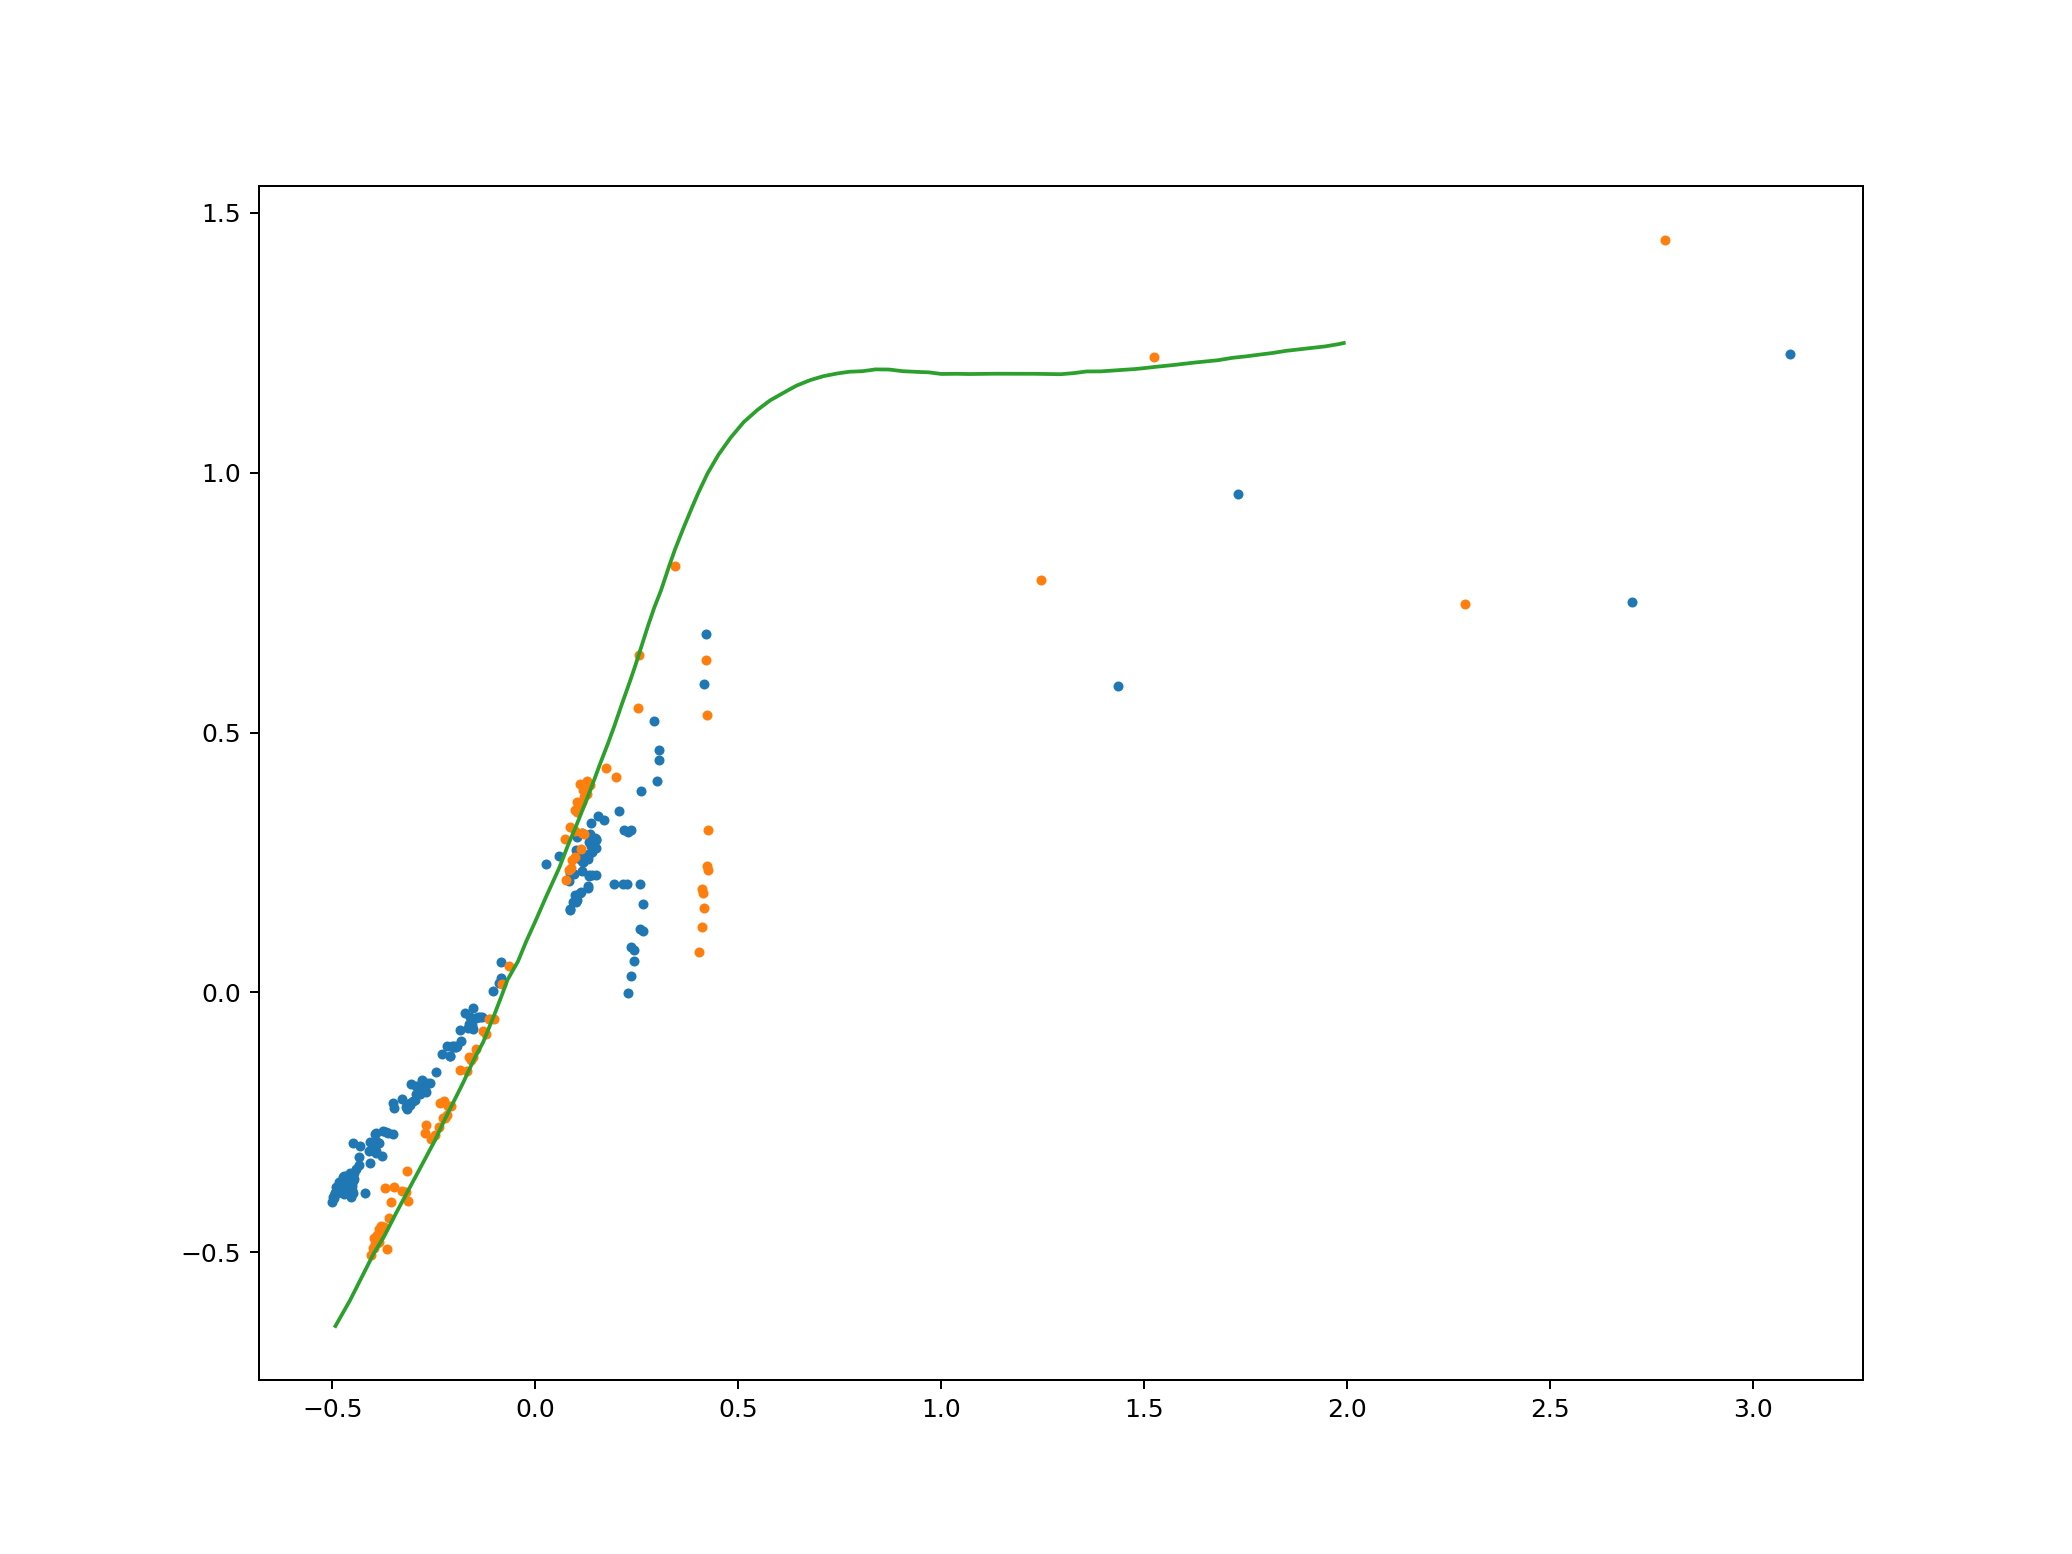

In [6]:
plt.figure()
plt.plot(smri,smgr,'.')
plt.plot(psri,psgr,'.')
plt.plot(tonry[:,0],tonry[:,1],'-')

The Tonry spline doesn't work for SM

In [7]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle

/Users/rridden/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject
  return f(*args, **kwds)


In [8]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1
catalog = 'II/358/smss'

c1 = SkyCoord(60.68043,-37.14869, frame='icrs', unit='deg')
result = Vizier.query_region(c1, catalog=[catalog],
                             radius=Angle(1.5, "deg"))
result = result[catalog].to_pandas()

In [9]:
result.keys()

Index(['ObjectId', 'RAICRS', 'DEICRS', 'e_RAICRS', 'e_DEICRS', 'SMSS',
       'EpMean', 'flags', 'ClassStar', 'RadrPetro', 'a', 'b', 'PA', 'uPSF',
       'uPetro', 'vPSF', 'vPetro', 'gPSF', 'gPetro', 'rPSF', 'rPetro', 'iPSF',
       'iPetro', 'zPSF', 'zPetro', '__u-v_PSF', '__u-g_PSF', '__g-r_PSF',
       '__g-i_PSF', '__i-z_PSF'],
      dtype='object')

In [10]:
gr = (result.gPSF - result.rPSF).values
ri = (result.rPSF - result.iPSF).values
ind = np.argsort(ri)
ri = ri[ind]
gr = gr[ind]
ind = (result.gPSF < 17) & (result.gPSF > 14)
ri = ri[ind]
gr = gr[ind]

x = np.arange(np.nanmin(smri),1.8,0.5)
y = []
for i in range(len(x)-1):
    ind = (ri > x[i]) & (ri < x[i+1])
    y += [np.nanmedian(gr[ind])]
y = np.array(y)
x = x[:-1]

<IPython.core.display.Javascript object>


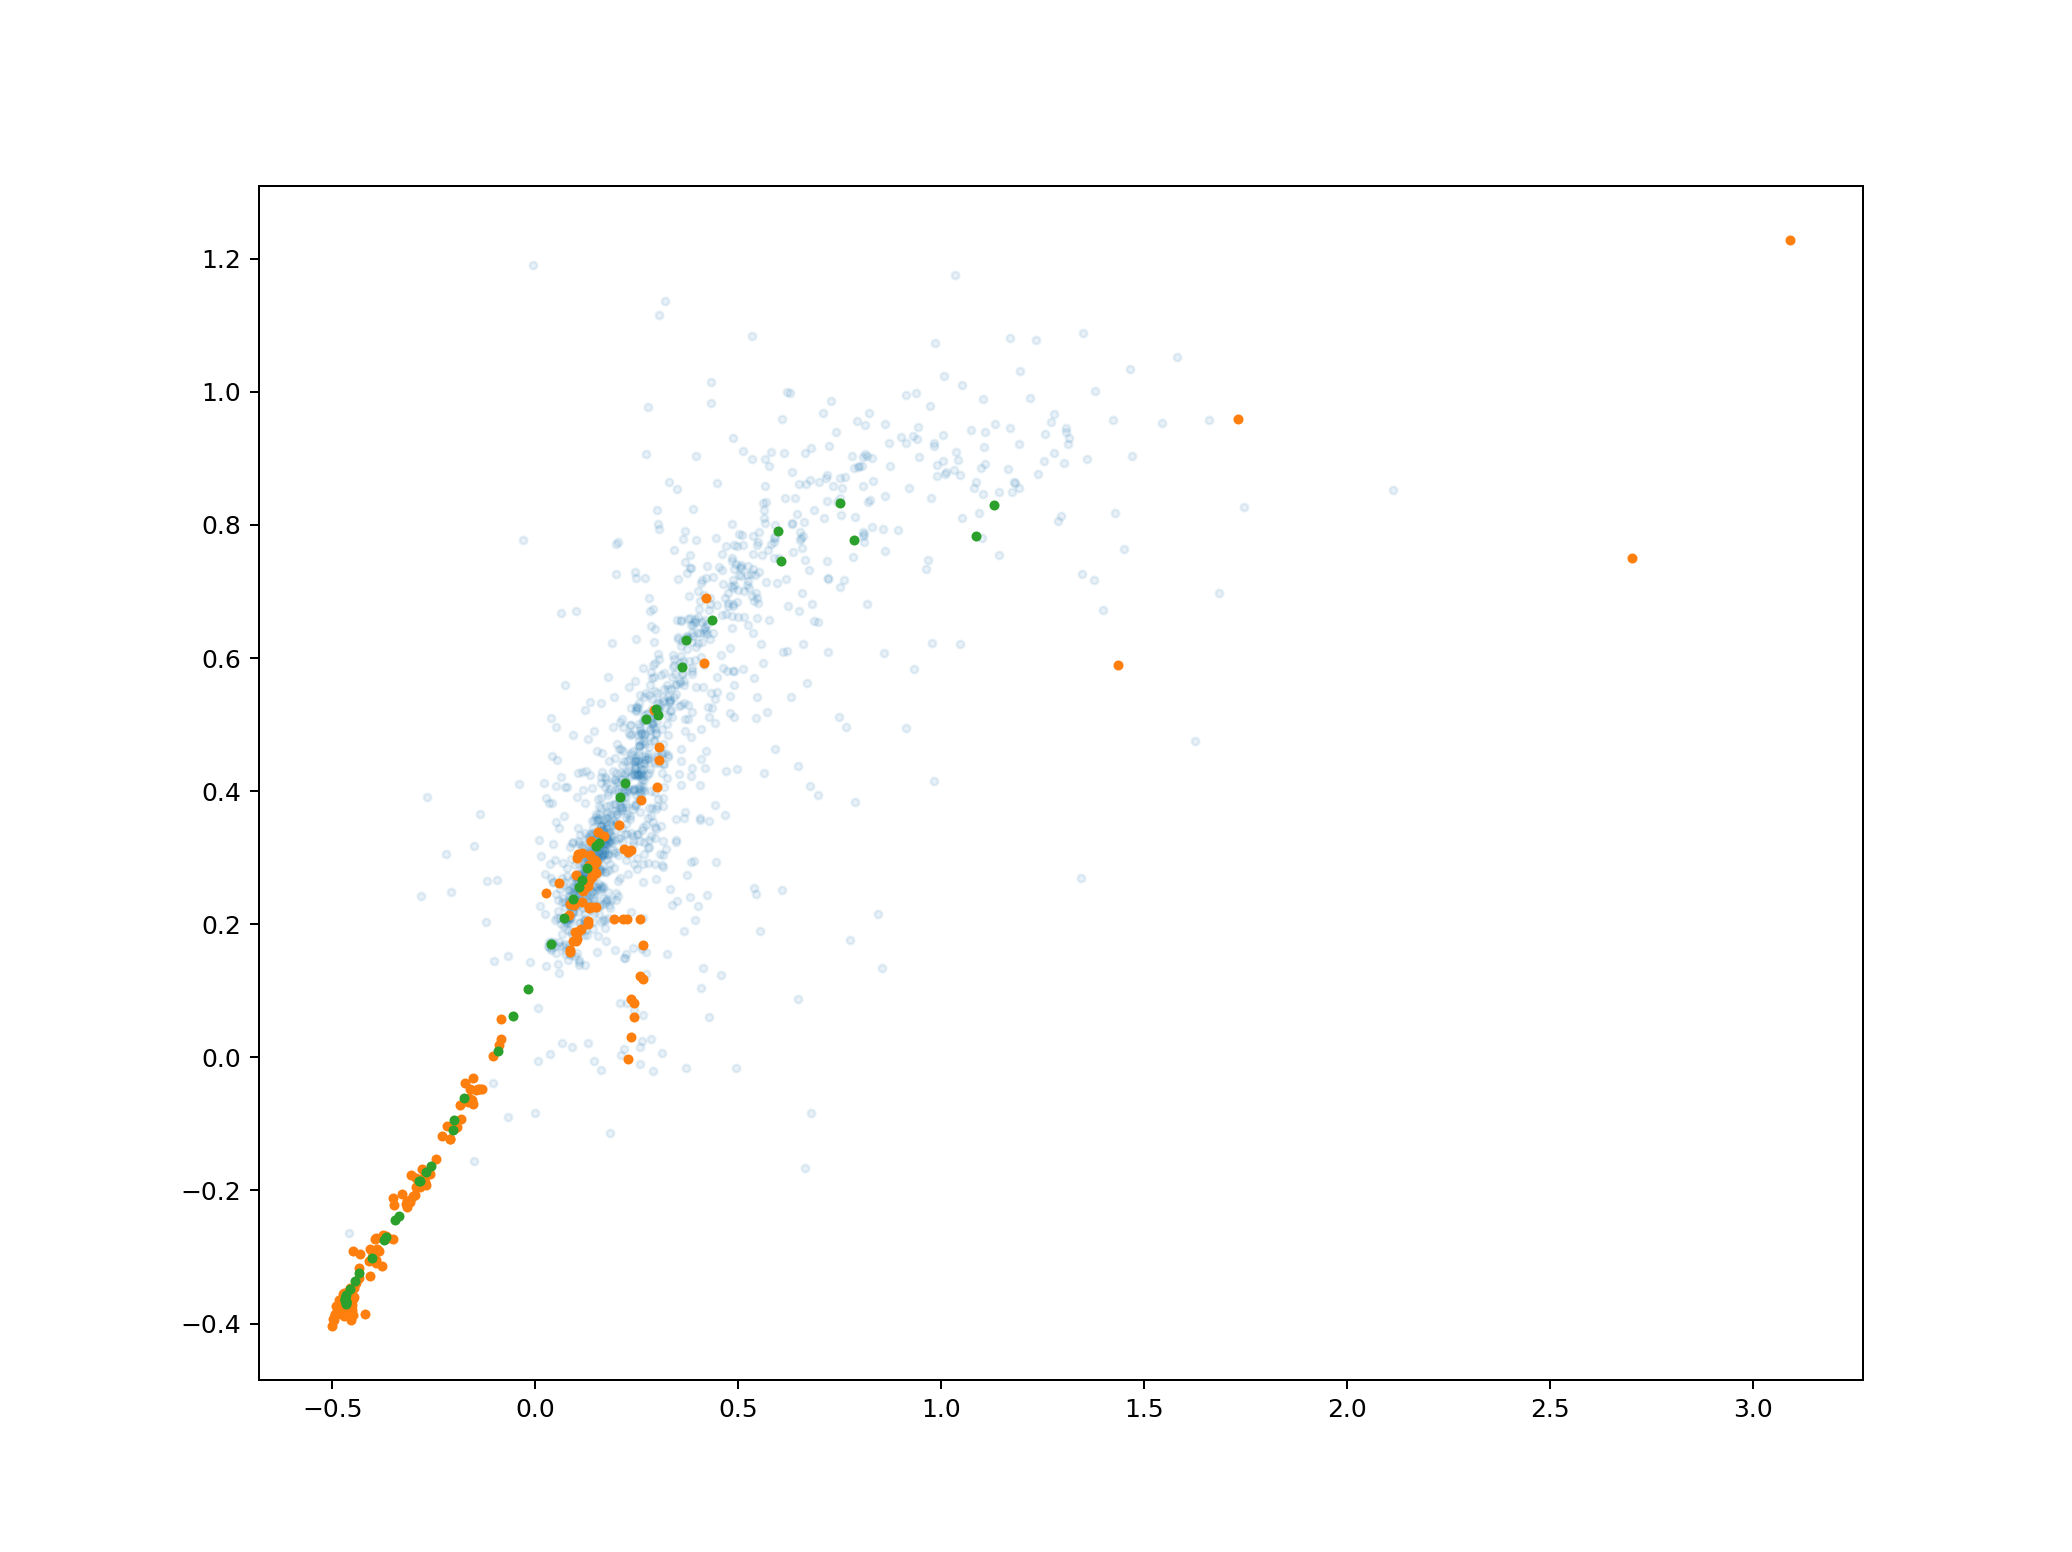

In [11]:
plt.figure()
plt.plot(ri,gr,'.',alpha=.1)
plt.plot(smri,smgr,'.')
plt.plot(ckri,ckgr,'.')
#plt.plot(psri,psgr,'.')
#plt.plot(tonry[:,0],tonry[:,1],'-')

In [19]:
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [20]:
ind = np.isfinite(ri) & np.isfinite(gr)

In [21]:
# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_x = dmatrix("bs(train, knots=(-0.4,0.55,1.12), degree=3, include_intercept=False)", {"train": ckri},return_type='dataframe')

# Fitting Generalised linear model on transformed dataset
fit1 = sm.GLM(ckgr, transformed_x).fit()

# Generating cubic spline with 4 knots
transformed_x2 = dmatrix("bs(train, knots=(-0.4,0.4,0.55,0.75,1.1),degree=3, include_intercept=False)", {"train": ckri}, return_type='dataframe')

# Fitting Generalised linear model on transformed dataset
fit2 = sm.GLM(ckgr, transformed_x2).fit()

# Generating natural cubic spline
transformed_x3 = dmatrix("cr(train,df = 5)", {"train": ckri}, return_type='dataframe')
fit3 = sm.GLM(ckgr, transformed_x3).fit()

In [22]:
xp = np.linspace(min(ckri),max(ckri),70)

pred1 = fit1.predict(dmatrix("bs(xp, knots=(-0.4,0.55,1.12),degree =3, include_intercept=False)", 
                             {"xp": xp}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(xp, knots=(-0.4,0.4,0.55,0.75,1.1),degree =3, include_intercept=False)", 
                             {"xp": xp}, return_type='dataframe'))
pred3 = fit3.predict(dmatrix("cr(valid, df=5)", {"valid": ckri}, return_type='dataframe'))


#x = ckri
transformed_x3 = dmatrix("cr(train,df = 5)", {"train": ckri}, return_type='dataframe')
fit3 = sm.GLM(ckgr, transformed_x3).fit()
pred3 = fit3.predict(dmatrix("cr(xp, df=5)", {"xp": xp}, return_type='dataframe'))
p = fit3.predict(dmatrix("cr(xp, df=5)", {"xp": ckri}, return_type='dataframe'))

<IPython.core.display.Javascript object>


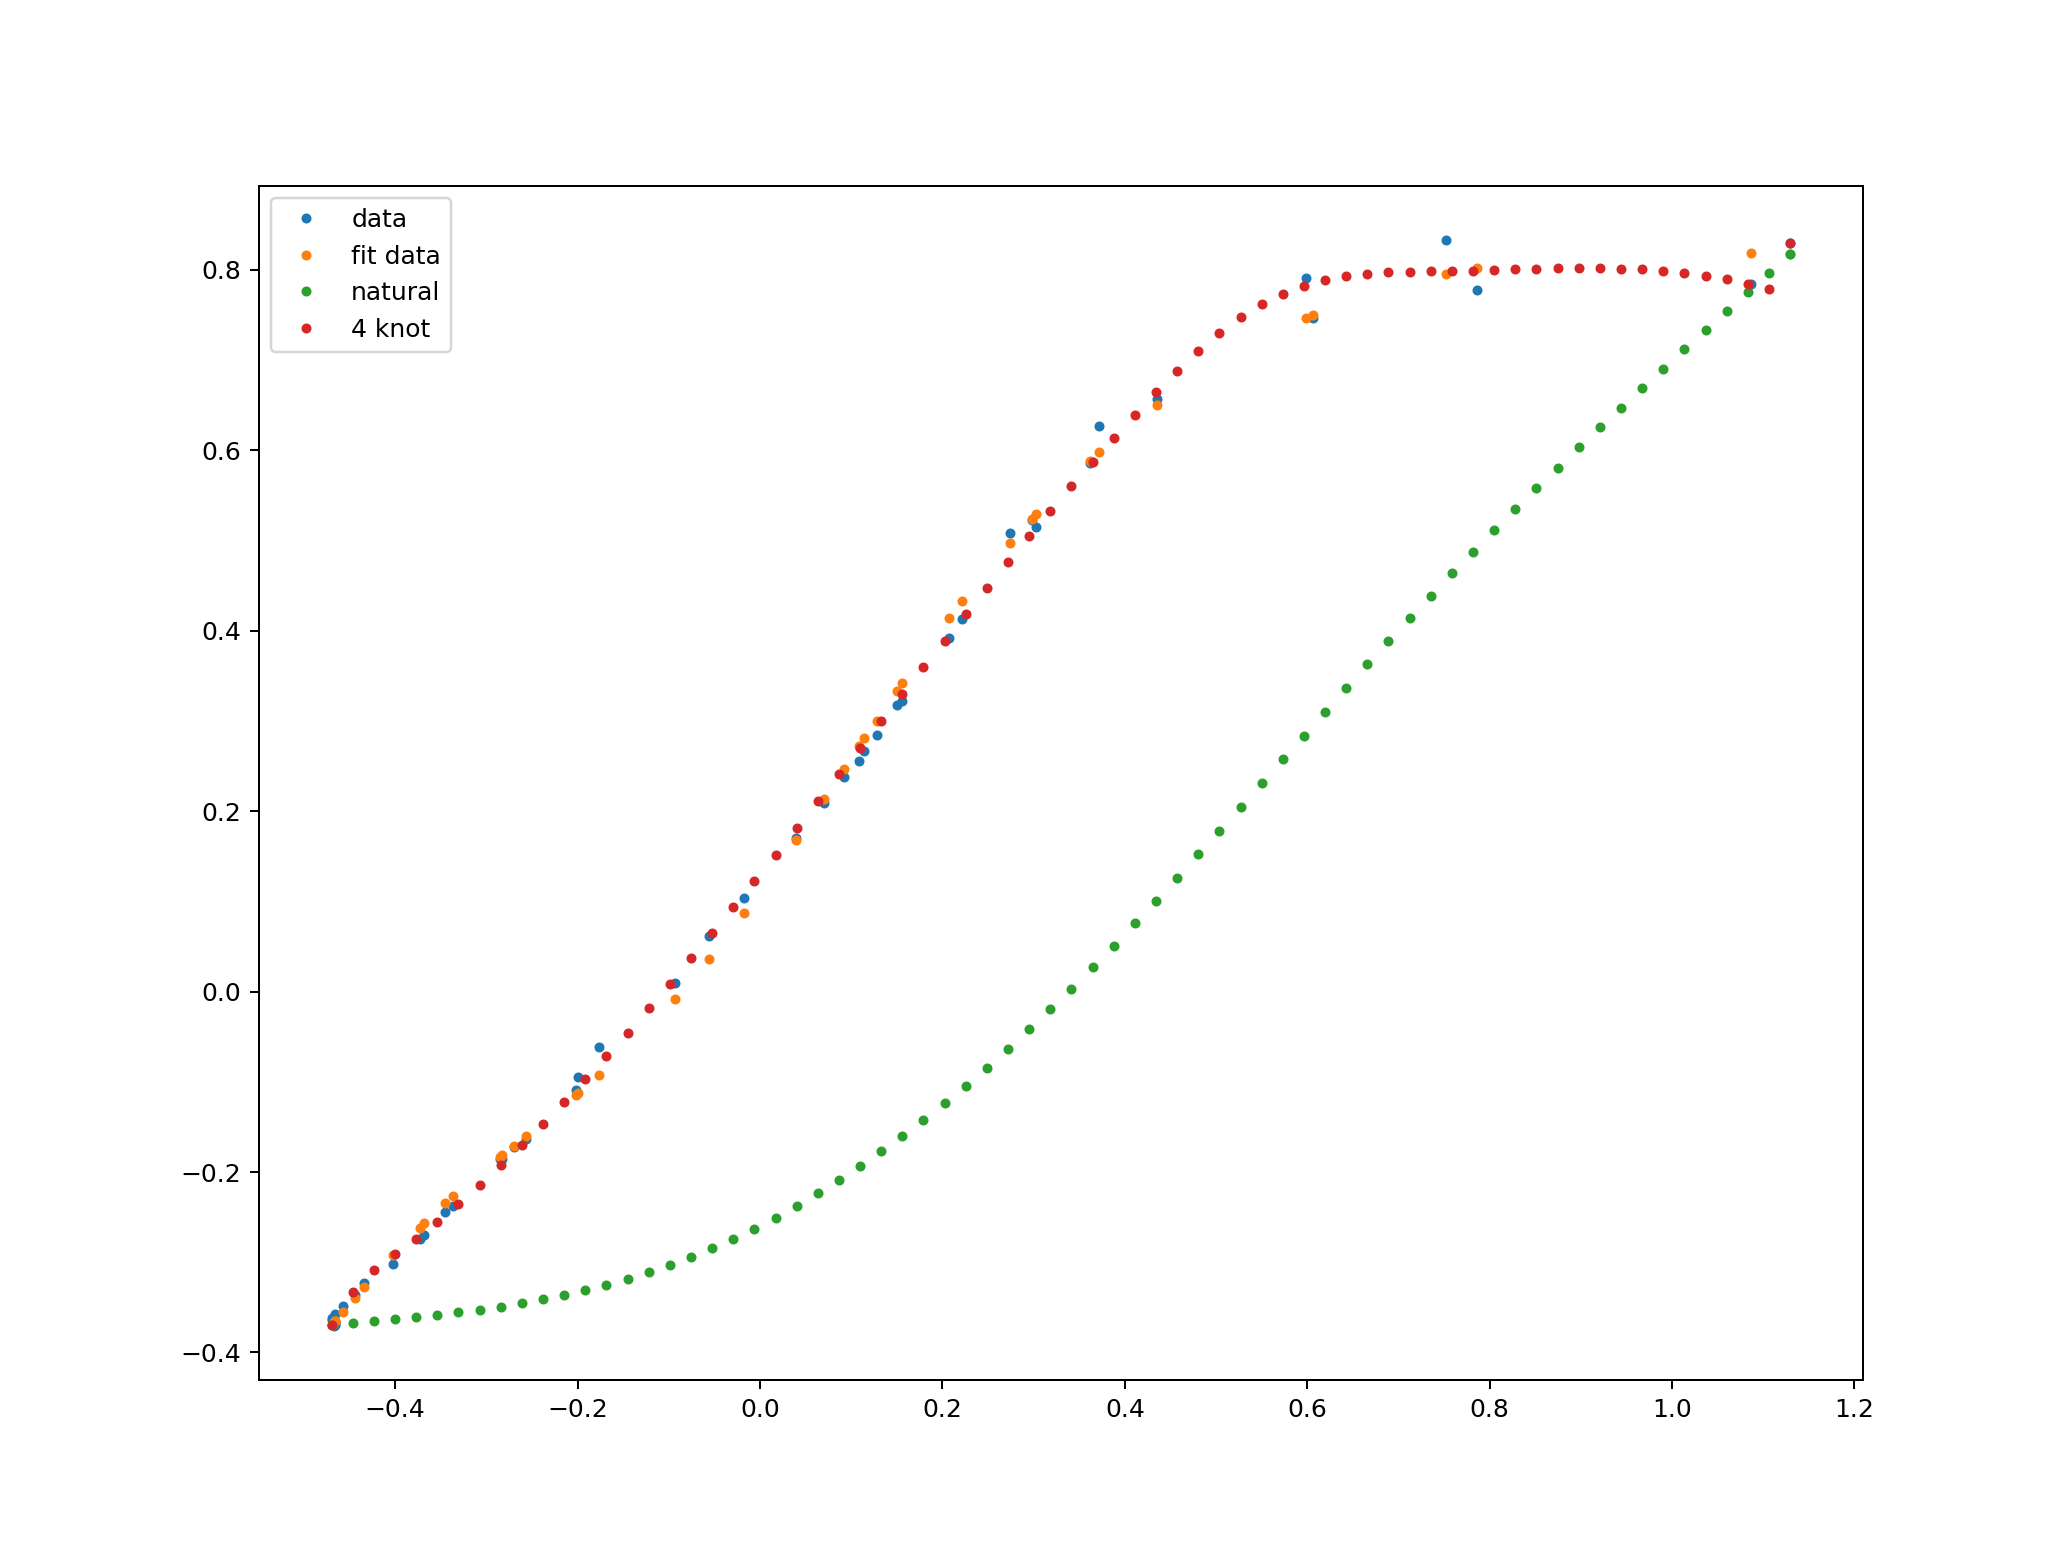

In [23]:
plt.figure()
#plt.plot(ri,gr,'.',alpha=.1)
plt.plot(ckri,ckgr,'.',label='data')

plt.plot(ckri,p.values,'.',label='fit data')
plt.plot(xp,pred3.values,'.',label='natural')
#plt.plot(xp,pred1.values,'.',label='3 knot')
plt.plot(xp,pred2.values,'.',label='4 knot')
plt.legend()


In [73]:
arr = np.array([xp,pred2.values])

In [75]:
np.savetxt('SMspline.txt',arr.T)

In [36]:
! cp SMspline.txt ../calibrimbore/calibrimbore/data/

# Try csaps

In [12]:
from csaps import csaps

In [34]:
x = ckri
y = ckgr
xs = np.linspace(x[0],x[-1],500)
ys = csaps(x,y,xs,smooth=0.999)

arr = np.array([xs,ys])
np.savetxt('SMspline.txt',arr.T)

<IPython.core.display.Javascript object>


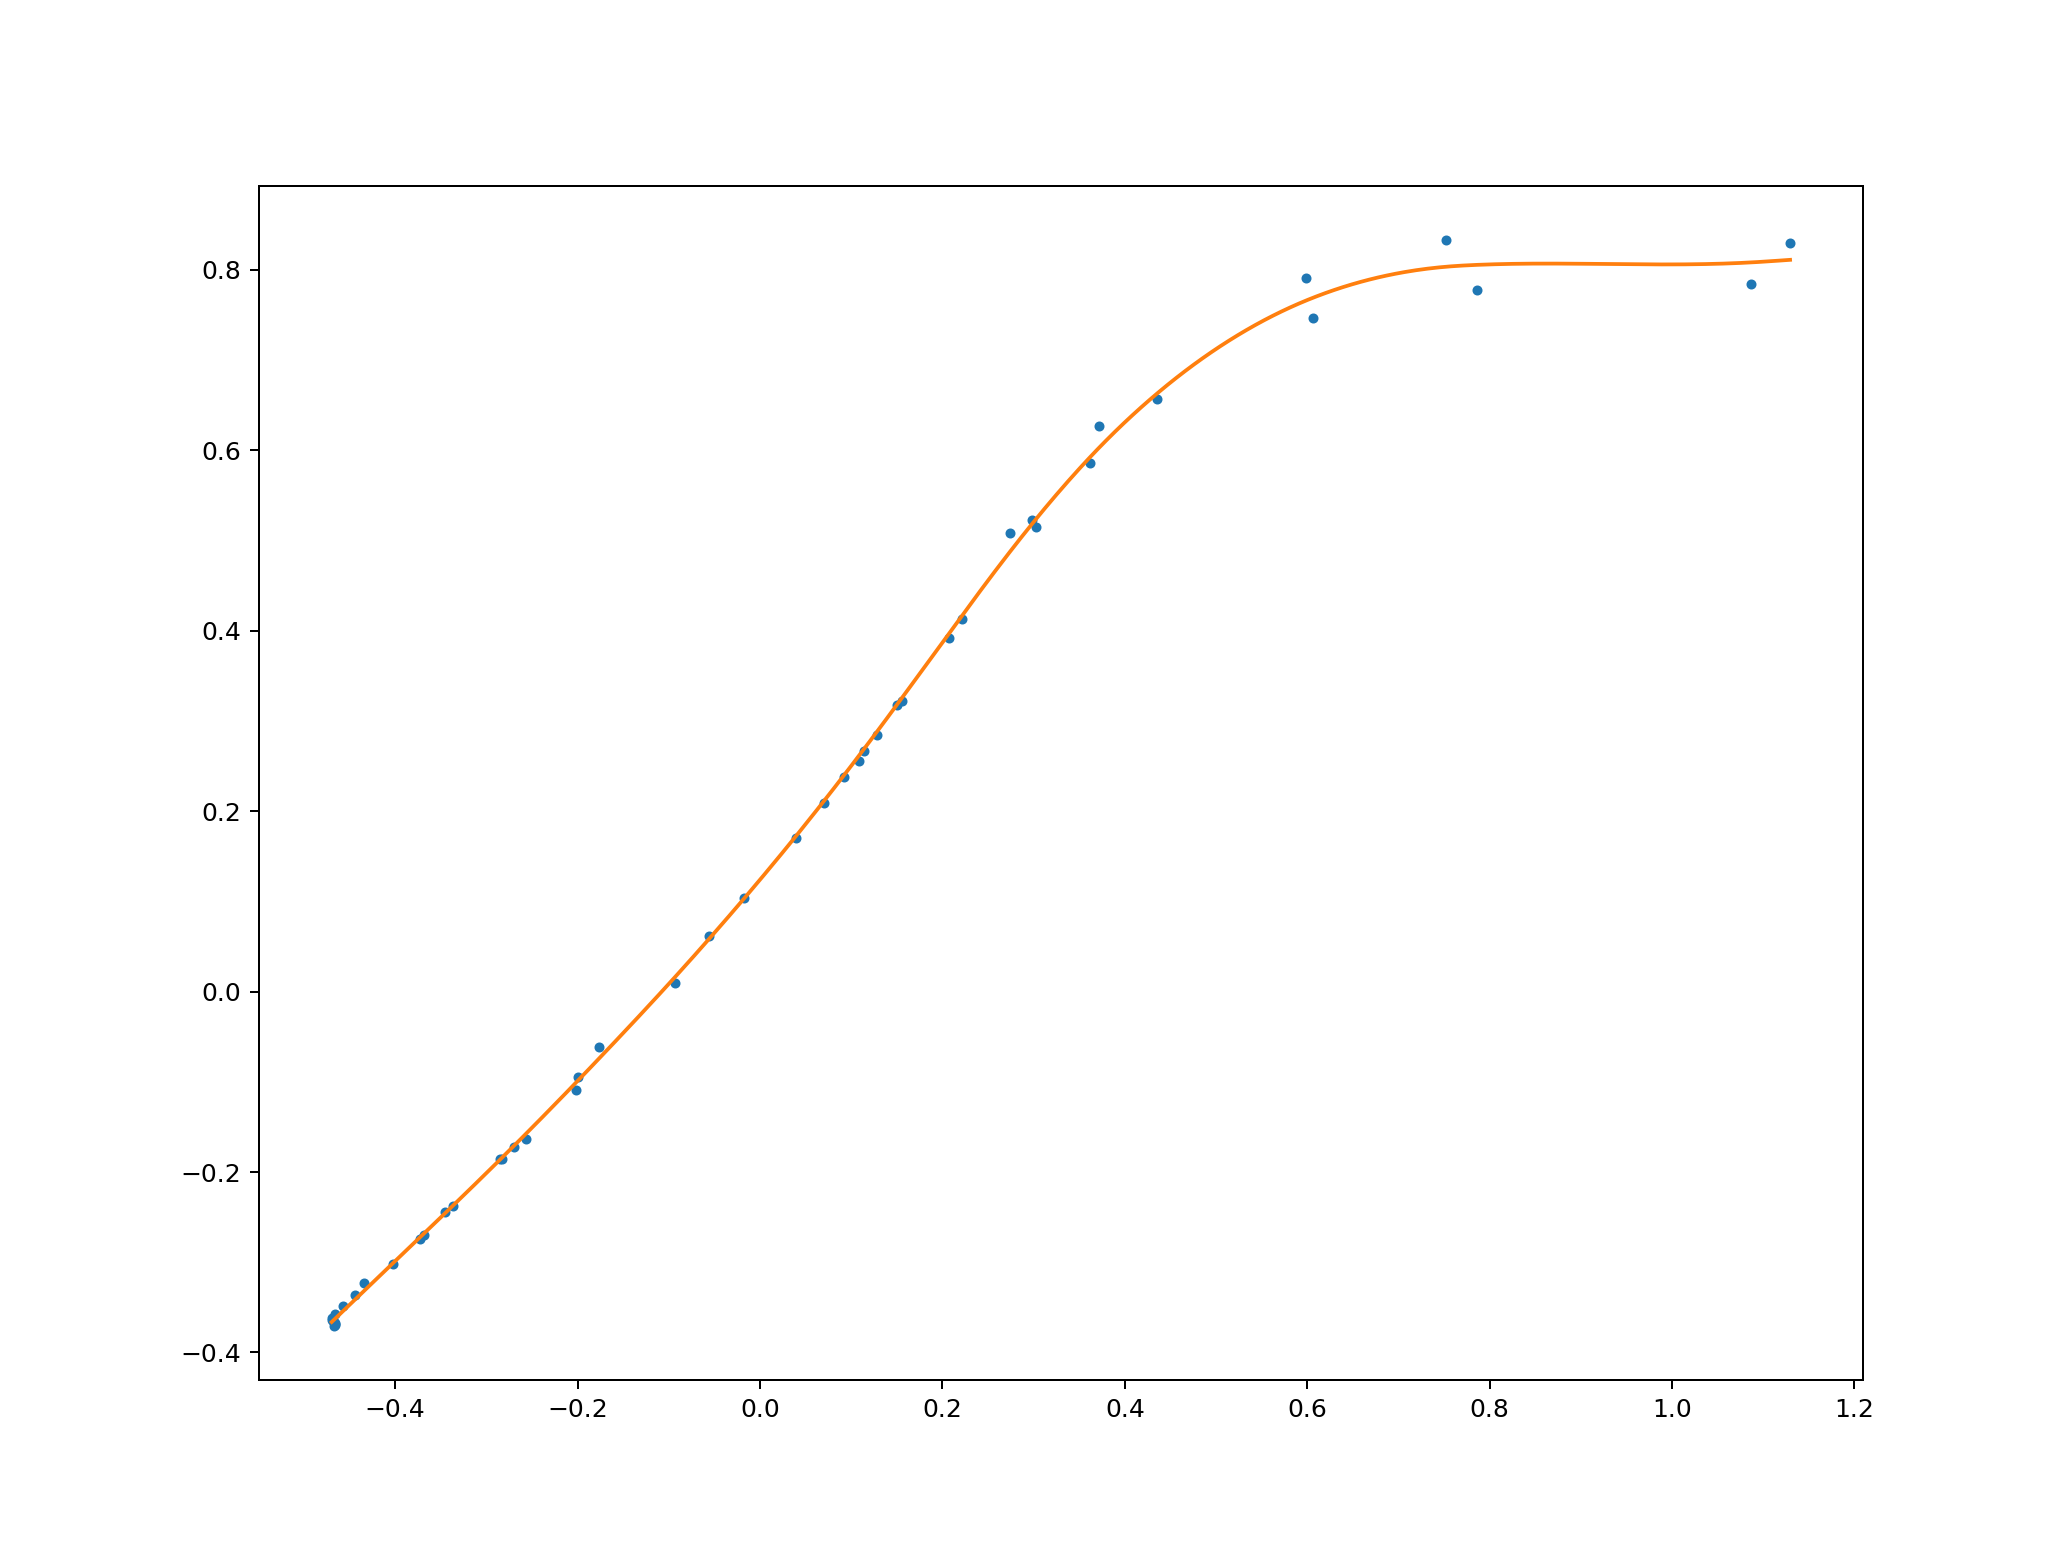

In [33]:
plt.figure()
plt.plot(x,y,'.')
plt.plot(xs,ys,'-')

In [24]:
from scipy.interpolate import UnivariateSpline

In [25]:
spl = UnivariateSpline(ckri, ckgr)
spl.set_smoothing_factor(1)

<IPython.core.display.Javascript object>


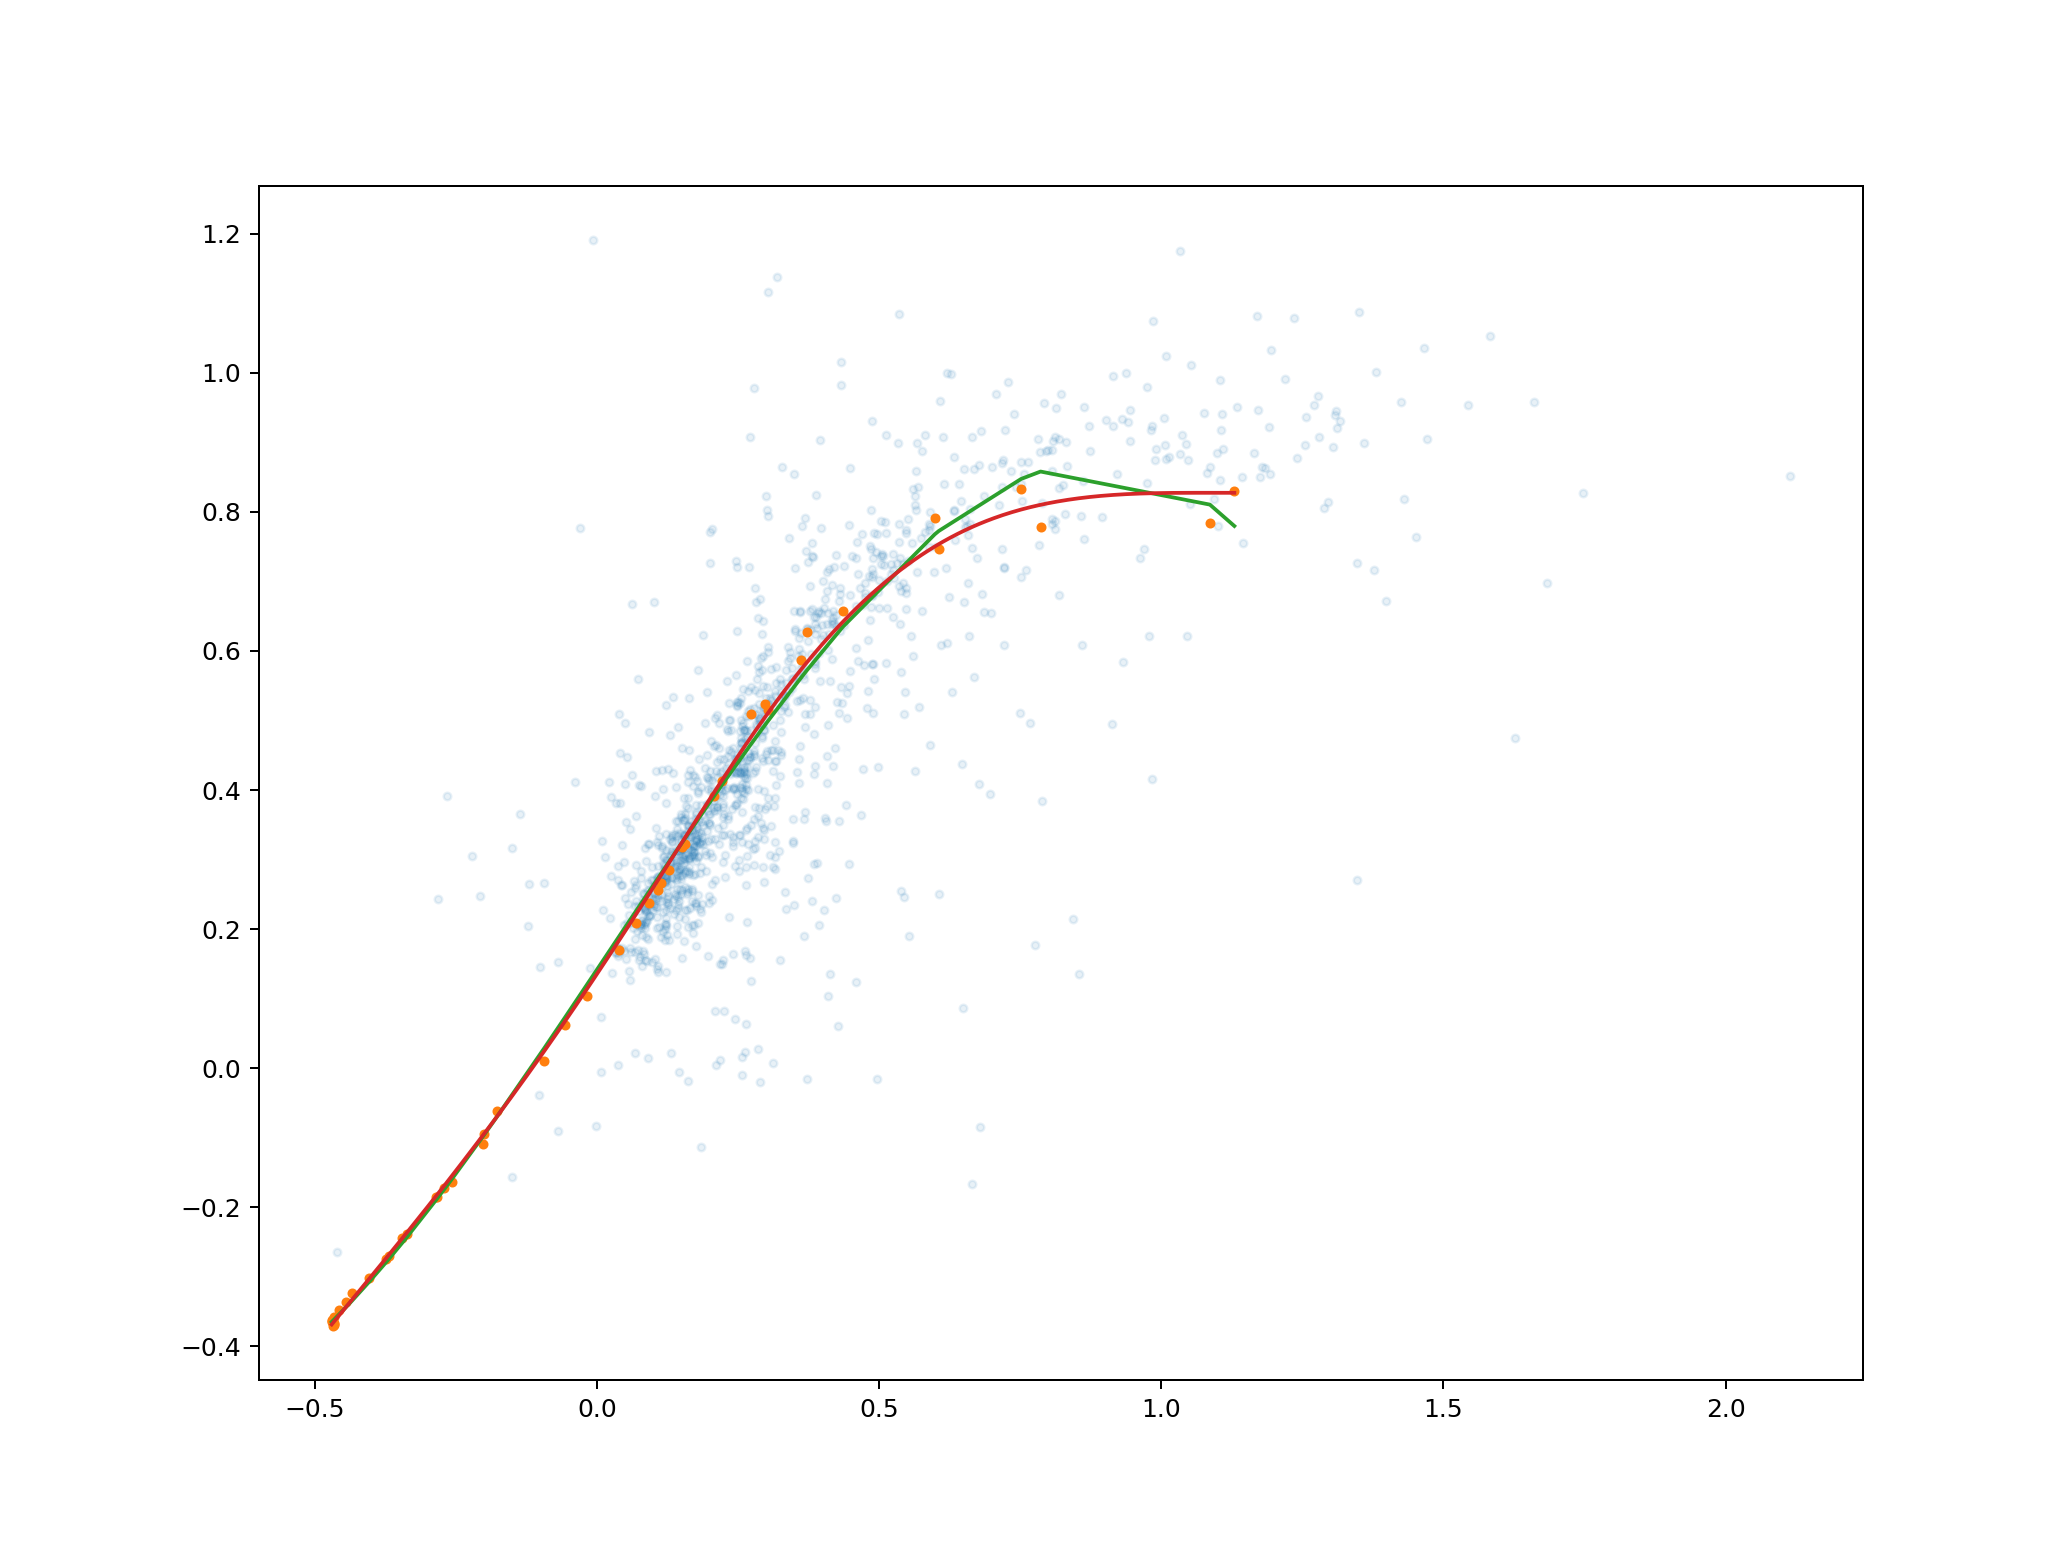

In [27]:
plt.figure()
plt.plot(ri,gr,'.',alpha=.1)
plt.plot(ckri,ckgr,'.')
plt.plot(ckri,spl(ckri))
plt.plot(xs,ys,'-')